# MultiModal RAG App for Video Processing With LlamaIndex and LanceDB
1. llamaindex framework
2. Lancedb Vector DataBase
3. LLM MultiModAl GPT-4V or Google-gemini-pro-vision

# Steps Need to follow:
1. Download video from YouTube, process and store it.

2. Build Multi-Modal index and vector store for both texts and images.

3. Retrieve relevant images and context, use both to augment the prompt.

4. Using GPT4V for reasoning the correlations between the input query and augmented data and generating final response.**

In [1]:
%pip install llama-index-vector-stores-lancedb
%pip install llama-index-multi-modal-llms-openai
%pip install llama-index-embeddings-clip
%pip install git+https://github.com/openai/CLIP.git
!pip install llama-index-readers-file

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-kwtlo7pw
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-kwtlo7pw
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cur

In [2]:
%pip install llama_index
%pip install -U openai-whisper

INFO: pip is looking at multiple versions of llama-cloud-services to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of llama-cloud-services to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.3/303.3 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 43.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisper-202

In [3]:

%pip install lancedb
%pip install moviepy
%pip install pytube
%pip install pydub
%pip install SpeechRecognition
%pip install ffmpeg-python
%pip install soundfile
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install ftfy regex tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 49.5 MB/s eta 0:00:00


**ffmpeg**-library enables you to use FFmpeg in Python to manipulate various media files for different purposes like building comprehensive multimedia applications, preprocessing media files.

**MoviePy** is a Python library for video editing, enabling cutting, concatenations, title insertions, video compositing, and effects like animations or color grading.

**Pytube** is a Python library used for downloading videos from YouTube. It supports downloading in various formats, resolutions, and also direct audio extraction.

**Pydub** is a Python library for audio manipulation, enabling easy loading, editing, and exporting of audio files in various formats with minimal code.

The **SpeechRecognition** library in Python allows you to convert spoken language into text using various engines and APIs, such as Google Speech Recognition, IBM Speech to Text, etc.

**SoundFile** is a Python library for reading from and writing to audio files, supporting many formats through the libsndfile library, ideal for high-quality audio processing.

**FTFY** (Fix Text For You) is a Python library that fixes broken Unicode text and mojibake (garbled text due to encoding issues), making text legible again.

**OpenAI Whisper** is a robust, multilingual speech recognition model developed by OpenAI. It converts speech into text and supports various languages with high accuracy.

**pprint** is a Python module that provides a capability to "pretty-print" complex data structures in a well-formatted and more readable way than the basic print function.

In [4]:
from moviepy.editor import VideoFileClip
from pathlib import Path
import speech_recognition as sr
from pytube import YouTube
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt

  if event.key is 'enter':

  from pkg_resources import resource_stream, resource_exists



In [5]:
import os
from google.colab import userdata
OPENAI_API_TOKEN=userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN

In [6]:
import os
print(os.getcwd())

/content


In [7]:
video_url="https://youtu.be/yIYKR4sgzI8?si=gXmg-aTIhioj1pOs"

In [8]:
output_video_path = "/content/video_data/"

In [9]:
# from the video we'll collect images,audio,text
output_folder = "/content/mixed_data/"
output_audio_path = "/content/mixed_data/output_audio.wav"

In [10]:
!mkdir mixed_data

In [11]:
filepath = output_video_path + "input_vid.mp4"
print(filepath)

/content/video_data/input_vid.mp4


---

### 1. The problem with **pytube**

* **Pytube** is a Python library that allows you to download YouTube videos, playlists, captions, etc.
* However, it **frequently breaks** because:

  * YouTube constantly updates its frontend JavaScript and API structure.
  * Pytube relies on parsing YouTube’s web pages and JavaScript to extract the **stream URLs** and metadata.
  * Even a small change in YouTube’s HTML/JS (e.g., renaming variables, changing request signatures) can cause errors like:

    * `RegexMatchError`
    * `VideoUnavailable`
    * `KeyError: 'cipher'`
  * Pytube maintainers are often slow to push fixes, so the library can stay broken for weeks.

---

### 2. What **pytubefix** does

* **pytubefix** is a **community-maintained fork** of pytube.
* Its main goal is to keep up with **YouTube’s frequent changes** more quickly.
* It fixes broken regex parsing and API issues whenever YouTube updates.

Key points:

* **Actively maintained** with patches for YouTube site changes.
* Supports **video download, audio extraction, playlists, captions** just like pytube.
* Handles **deciphering video stream URLs** (the “ciphered signatures” issue that breaks pytube often).
* Often provides more **accurate video metadata and stats** (views, title, length, publish date, description, etc.) because its parsing scripts are updated.

---

### 3. Example: Video Stats Issue

In pytube:

```python
from pytube import YouTube

yt = YouTube("https://www.youtube.com/watch?v=abc123")
print(yt.views)   # might fail or give wrong result if regex broke
```

If YouTube updated their JS, you might get:

* Wrong views count
* Errors like `RegexMatchError`

In pytubefix:

```python
from pytubefix import YouTube

yt = YouTube("https://www.youtube.com/watch?v=abc123")
print(yt.views)   # works, because fix updated regex
```

---

✅ **In short:**

* **pytube breaks often** because YouTube changes its frontend.
* **pytubefix** is a fork that patches those issues quickly, making downloads and video stats retrieval work reliably.



In [12]:
!pip install pytubefix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 768.6/768.6 kB 23.8 MB/s eta 0:00:00


In [13]:
from pytubefix import YouTube
def download_video(url,output_path):
  video_id = url.split('?')[0].split('/')[-1]
  watch_url = f"https://www.youtube.com/watch?v={video_id}"


  yt = YouTube(watch_url)  #   from pytubefix, not pytube
  metadata = {"Author": yt.author, "Title": yt.title, "Views": yt.views}

  yt.streams.get_highest_resolution().download(
        output_path=output_path, filename="input_vid.mp4"
    )
  return metadata

In [14]:
from moviepy.editor import VideoFileClip
def video_to_images(video_path,output_folder):
  clip=VideoFileClip(video_path)
  clip.write_images_sequence(
      os.path.join(output_folder,"frame%04d.png"),fps=0.2
  )

In [15]:
def video_to_audio(video_path,output_audio_path):
  clip=VideoFileClip(video_path)
  audio=clip.audio
  audio.write_audiofile(output_audio_path)

In [16]:
def audio_to_text(audio_path):
  recognizer=sr.Recognizer()
  audio=sr.AudioFile(audio_path)

  with audio as source:
    audio_data=recognizer.record(source)

    try:

      #recognize the speech
      text = recognizer.recognize_whisper(audio_data)

    except sr.UnknownValueError:
      print("Speech recognition could not understand the audio.")
  return text

In [17]:
video_url

'https://youtu.be/yIYKR4sgzI8?si=gXmg-aTIhioj1pOs'

In [18]:
output_video_path

'/content/video_data/'

In [19]:
metadata=download_video(video_url,output_video_path)
metadata

{'Author': 'StatQuest with Josh Starmer',
 'Title': 'StatQuest: Logistic Regression',
 'Views': 2506935}

In [20]:
video_to_images(filepath,output_folder)

Moviepy - Writing frames /content/mixed_data/frame%04d.png.


Moviepy - Done writing frames /content/mixed_data/frame%04d.png.


In [21]:
filepath

'/content/video_data/input_vid.mp4'

In [22]:
output_audio_path

'/content/mixed_data/output_audio.wav'

In [23]:
video_to_audio(filepath,output_audio_path)

MoviePy - Writing audio in /content/mixed_data/output_audio.wav


MoviePy - Done.


In [24]:
text_data=audio_to_text(output_audio_path)

100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 76.0MiB/s]


In [25]:
text_data

" If you can fit a line, you can fit a squiggle. If you can make me laugh, you can make me giggle. StatQuest. Hello, I'm Josh Starmer and welcome to StatQuest. Today we're going to talk about logistic regression. This is a technique that can be used for traditional statistics as well as machine learning. So let's get right to it. Before we dive into logistic regression, let's take a step back and review linear regression. In another StatQuest, we talked about linear regression. We had some data, weight and size. Then we fit a line to it. And with that line, we could do a lot of things. First, we could calculate R squared and determine if weight and size are correlated. Large values imply a large effect. And second, calculate a p-value to determine if the R squared value is statistically significant. And third, we could use the line to predict size given weight. If a new mouse has this weight, then this is the size that we predict from the weight. Although we didn't mention it at the ti

 If you can fit a line, you can fit a squiggle. If you can make me laugh, you can make me giggle. StatQuest. Hello, I'm Josh Starmer and welcome to StatQuest. Today we're going to talk about logistic regression. This is a technique that can be used for traditional statistics as well as machine learning. So let's get right to it. Before we dive into logistic regression, let's take a step back and review linear regression. In another StatQuest, we talked about linear regression. We had some data, weight and size. Then we fit a line to it. And with that line, we could do a lot of things. First, we could calculate R squared and determine if weight and size are correlated. Large values imply a large effect. And second, calculate a p-value to determine if the R squared value is statistically significant. And third, we could use the line to predict size given weight. If a new mouse has this weight, then this is the size that we predict from the weight. Although we didn't mention it at the time, using data to predict something falls under the category of machine learning. So plain old linear regression is a form of machine learning. We also talked a little bit about multiple regression. Now we are trying to predict size using weight and blood volume. Alternatively, we could say that we are trying to model size using weight and blood volume. Multiple regression did the same things that normal regression did. We calculated R squared and we calculated the p-value. And we could predict size using weight and blood volume. And this makes multiple regression a slightly fancier machine learning method. We also talked about how we can use discrete measurements like genotype to predict size. If you're not familiar with the term genotype, don't freak out. It's no big deal. Just know that it refers to different types of mice. Lastly, we could compare models. So on the left side, we've got normal regression using weight to predict size. And we can compare those predictions to the ones we get from multiple regression where we're using weight and blood volume to predict size. Comparing the simple model to the complicated one tells us if we need to measure weight and blood volume to accurately predict size. Or if we can get away with just weight. Now that we remember all the cool things we can do with linear regression, let's talk about logistic regression. Logistic regression is similar to linear regression except logistic regression predicts whether something is true or false instead of predicting something continuous like size. These mice are obese and these mice are not. Also, instead of fitting a line to the data, logistic regression fits an S-shaped logistic function. The curve goes from 0 to 1. And that means that the curve tells you the probability that a mouse is obese based on its weight. If we weighed a very heavy mouse, there's a high probability that the new mouse is obese. If we weighed an intermediate mouse, then there's only a 50% chance that the mouse is obese. Lastly, there's only a small probability that a light mouse is obese. Although logistic regression tells the probability that a mouse is obese or not, it's usually used for classification. For example, if the probability a mouse is obese is greater than 50%, then we'll classify it as obese. Otherwise, we'll classify it as not obese. Just like with linear regression, we can make simple models. In this case, we can have obesity predicted by weight, or more complicated models. In this case, obesity is predicted by weight and genotype. In this case, obesity is predicted by weight and genotype and age. And lastly, obesity is predicted by weight, genotype, age, and astrological sign. In other words, just like linear regression, logistic regression can work with continuous data, like weight and age, and discrete data, like genotype and astrological sign. We can also test to see if each variable is useful for predicting obesity. However, unlike normal regression, we can't easily compare the complicated model to the simple model, and we'll talk more about why in a bit. Instead, we just test to see if a variable's effect on the prediction is significantly different from zero. If not, it means that the variable is not helping the prediction. Psst! We use Wald's test to figure this out. We'll talk about that in another stack quest. In this case, the astrological sign is totes useless. That's statistical jargon for not helping. That means we can save time and space in our study by leaving it out. Logistic regressions' ability to provide probabilities and classify new samples using continuous and discrete measurements makes it a popular machine learning method. One big difference between linear regression and logistic regression is how the line is fit to the data. With linear regression, we fit the line using least squares. In other words, we find the line that minimizes the sum of the squares of these residuals. We also use the residuals to calculate R squared and to compare simple models to complicated models. Logistic regression doesn't have the same concept of a residual, so it can't use least squares and it can't calculate R squared. Instead, it uses something called maximum likelihood. There's a whole stack quest on maximum likelihood, so see that for details, but in a nutshell, you pick a probability scaled by weight of observing an obese mouse, just like this curve. And you use that to calculate the likelihood of observing a non-obese mouse that weighs this much. And then you calculate the likelihood of observing this mouse. And you do that for all of the mice. And lastly, you multiply all of those likelihoods together. That's the likelihood of the data given this line. Then you shift the line and calculate a new likelihood of the data. And then shift the line and calculate the likelihood again. And again. Finally, the curve with the maximum value for the likelihood is selected. Bam! In summary, logistic regression can be used to classify samples. And it can use different types of data, like size and or genotype, to do that classification. And it can also be used to assess what variables are useful for classifying samples. I.e. astrological sign is totes useless. Hooray! We've made it to the end of another exciting stack quest. If you like this stack quest and want to see more, please subscribe. Many feedback suggestions for future stack quests. Well, put them in the comments below. Until next time, quest on!

In [26]:
with open(output_folder + "output_text.txt", "w") as file:
        file.write(text_data)
print("Text data saved to file")
file.close()

Text data saved to file


In [27]:
# os.remove(output_audio_path)
# print("Audio file removed")  # Optional process since we have already generated text data from audio file so we use that text data and convert it into embeddings ......

In [28]:
# processing the video......
# images , text data

go through this ---https://github.com/run-llama/llama_index/blob/main/llama-index-core/llama_index/core/indices/multi_modal/base.py to  know more about class MultiModalVectorStoreIndex

## LlamaIndex Core Classes Explained

### **MultiModalVectorStoreIndex**

The **MultiModalVectorStoreIndex** is a specialized index class in LlamaIndex designed to handle multi-modal data - specifically text and images. This class extends the functionality of the standard VectorStoreIndex to support multiple data modalities within a single indexing structure.[1][2]

**Key Features:**
- **Multi-Modal Support**: Can process both text documents and images simultaneously[1]
- **Separate Vector Stores**: Maintains distinct vector stores for text and image embeddings, allowing for optimized storage and retrieval of different data types[1]
- **Flexible Embedding Models**: Supports arbitrary text embedding models (default is GPT-3.5) and image embedding models (default is CLIP)[1]
- **Retrieval Capabilities**: Enables text-to-text, text-to-image, and image-to-image retrieval operations[1]

**Usage Example:**
```python
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.vector_stores.qdrant import QdrantVectorStore

# Create separate vector stores for text and images
text_store = QdrantVectorStore(client=client, collection_name="text_collection")
image_store = QdrantVectorStore(client=client, collection_name="image_collection")

# Set up storage context with both stores
storage_context = StorageContext.from_defaults(
    vector_store=text_store,
    image_store=image_store
)

# Load documents (can include both text and images)
documents = SimpleDirectoryReader("./data_folder/").load_data()

# Create the multi-modal index
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context
)
```

**Class Properties:**
- Inherits from `VectorStoreIndex`
- Has an `image_namespace` property set to "image"
- Uses `MultiModelIndexDict` as its index structure[2]

### **SimpleDirectoryReader**

The **SimpleDirectoryReader** is LlamaIndex's primary data loading utility that automatically reads and processes various file types from directories. It serves as the entry point for ingesting documents into LlamaIndex workflows.[3]

**Core Functionality:**
- **Automatic File Detection**: Automatically detects and processes supported file formats including PDF, DOCX, TXT, CSV, and many others[3]
- **Recursive Directory Reading**: Can traverse subdirectories when `recursive=True` is set[3]
- **Parallel Processing**: Supports multi-worker processing for faster file loading[3]
- **Metadata Extraction**: Automatically extracts file metadata such as file path, name, type, size, and timestamps[4]

**Key Parameters:**
- `input_dir`: The directory path to read files from
- `input_files`: Specific list of files to load (alternative to directory scanning)
- `recursive`: Whether to read files from subdirectories
- `file_extractor`: Custom mapping of file extensions to reader classes
- `exclude`: List of files to exclude from loading
- `num_workers`: Number of parallel workers for processing[3]

**Usage Examples:**
```python
from llama_index.core import SimpleDirectoryReader

# Basic usage - load all supported files from directory
reader = SimpleDirectoryReader(input_dir="path/to/directory")
documents = reader.load_data()

# Load with parallel processing
documents = reader.load_data(num_workers=4)

# Load recursively from subdirectories
reader = SimpleDirectoryReader(input_dir="path/to/directory", recursive=True)
documents = reader.load_data()

# Iterate over files as they load
for docs in reader.iter_data():
    # Process documents per file
    all_docs.extend(docs)
```

**Document Structure:**
Each document returned by `load_data()` contains:[4]
- `text`: The extracted content from the file
- `metadata`: Dictionary with file information (file_path, file_name, file_type, etc.)
- `id_`: Optional document identifier (can be set to filename with `filename_as_id=True`)

**Extensibility:**
The reader can be extended to support custom file types by providing a `file_extractor` dictionary mapping file extensions to custom `BaseReader` implementations.[3]

### **StorageContext**

The **StorageContext** is LlamaIndex's central storage management class that provides a unified interface for handling different storage backends. It acts as a container that coordinates between document storage, index storage, and vector storage.[5][6]

**Core Components:**
The StorageContext manages three main storage types:[6][5]
- **Document Store (docstore)**: Stores the actual document nodes and their content
- **Index Store (index_store)**: Stores index metadata and structural information
- **Vector Store (vector_store)**: Stores embedding vectors for similarity search

**Key Methods:**

**`from_defaults()` Class Method:**
Creates a StorageContext with default configurations, allowing customization of individual components:[5][6]
```python
from llama_index.core import StorageContext

# Create with all defaults
storage_context = StorageContext.from_defaults()

# Create with custom vector store
storage_context = StorageContext.from_defaults(
    vector_store=custom_vector_store,
    persist_dir="./my_storage"
)

# Create with custom components
storage_context = StorageContext.from_defaults(
    docstore=custom_docstore,
    index_store=custom_index_store,
    vector_store=custom_vector_store
)
```

**`persist()` Method:**
Saves all storage components to disk:[5]
```python
# Persist to default location (./storage)
storage_context.persist()

# Persist to custom directory
storage_context.persist(persist_dir="./my_custom_storage")
```

**`add_vector_store()` Method:**
Allows adding additional vector stores with custom namespaces for multi-modal or specialized use cases.[5]

**Storage Backends:**
StorageContext supports various storage backends through different store implementations:[7]
- **Local Filesystem**: Default option for development and small-scale applications
- **MongoDB**: For distributed document and index storage
- **Redis**: For high-performance caching and storage
- **Cloud Storage**: AWS S3, Azure, Google Cloud through fsspec integration

**Persistence and Loading:**
```python
# Save index and context
index.storage_context.persist(persist_dir="./storage")

# Load from saved state
from llama_index.core import load_index_from_storage

storage_context = StorageContext.from_defaults(persist_dir="./storage")
index = load_index_from_storage(storage_context)
```

**Integration with Indexes:**
StorageContext is typically used when creating indexes to specify where and how data should be stored:
```python
# Use with VectorStoreIndex
index = VectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context
)

# Use with MultiModalVectorStoreIndex
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context
)
```

The StorageContext provides flexibility in data persistence, allowing developers to choose appropriate storage backends based on their application's scale, performance requirements, and infrastructure constraints.[8][9]

[1] https://docs.llamaindex.ai/en/stable/module_guides/models/multi_modal/
[2] https://github.com/run-llama/llama_index/blob/main/llama-index-core/llama_index/core/indices/multi_modal/base.py
[3] https://docs.llamaindex.ai/en/stable/module_guides/loading/simpledirectoryreader/
[4] https://github.com/run-llama/llama_index/discussions/11970
[5] https://docs.llamaindex.ai/en/stable/api_reference/storage/storage_context/
[6] https://docs.llamaindex.ai/en/v0.10.18/api_reference/storage.html
[7] https://github.com/run-llama/llama_index/blob/main/docs/docs/module_guides/storing/index_stores.md
[8] https://nanonets.com/blog/llamaindex/
[9] https://www.gettingstarted.ai/llamaindex-storage-customization-persisting-and-loading-data/
[10] https://docs.llamaindex.ai/en/stable/module_guides/indexing/vector_store_index/
[11] https://github.com/run-llama/llama_index/issues/13102
[12] https://pypi.org/project/llama-index/
[13] https://llama-index.readthedocs.io/zh/stable/reference/storage.html
[14] https://stackoverflow.com/questions/77984729/importerror-cannot-import-name-vectorstoreindex-from-llama-index-unknown-l
[15] https://docs.llmhub.t-systems.net/Model%20Serving/llama-index
[16] https://docs.llamaindex.ai/en/v0.10.19/api_reference/storage.html
[17] https://docs.llamaindex.ai/en/stable/understanding/storing/storing/
[18] https://qdrant.tech/documentation/frameworks/llama-index/
[19] https://docs.llamaindex.ai/en/v0.9.48/api/llama_index.readers.SimpleDirectoryReader.html
[20] https://wentao.site/llama_index_2/
[21] https://stackoverflow.com/questions/78125440/loading-data-with-llama-index-after-upgrading-package-cant-find-readers-file
[22] https://docs.pinecone.io/integrations/llamaindex
[23] https://stackoverflow.com/questions/76832028/importerror-cannot-import-name-simpledirectoryreader-from-llama-index-unkn
[24] https://github.com/run-llama/llama_index/issues/10621
[25] https://huggingface.co/llamaindex
[26] https://stackoverflow.com/questions/76837143/llamaindex-index-storage-context-persist-not-storing-vector-store
[27] https://llamaindexxx.readthedocs.io/en/latest/api_reference/storage.html
[28] https://www.youtube.com/watch?v=Cu5KQz3c4Zk
[29] https://github.com/run-llama/llama_index/issues/2499
[30] https://github.com/run-llama/llama_index/issues/12571
[31] https://llama-index.readthedocs.io/zh/stable/how_to/storage/save_load.html
[32] https://github.com/run-llama/llama_index

In [29]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import SimpleDirectoryReader
from llama_index.core import StorageContext

In [30]:
from llama_index.vector_stores.lancedb import LanceDBVectorStore

In [31]:
text_store=LanceDBVectorStore(uri="lancedb",table_name="text_collection")
image_store=LanceDBVectorStore(uri="lancedb",table_name="image_collection")

In [32]:
storage_context=StorageContext.from_defaults(vector_store=text_store,image_store=image_store)

In [33]:
output_folder

'/content/mixed_data/'

In [34]:
documents=SimpleDirectoryReader(output_folder).load_data()

In [35]:
index = MultiModalVectorStoreIndex.from_documents(documents,storage_context=storage_context)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 144MiB/s]


In [36]:
retriever_engine=index.as_retriever(similarity_top_k=3, image_similarity_top_k=10)

In [37]:
qa_tmpl_str=(
    "Based on the provided information, including relevant images and retrieved context from the video, \
    accurately and precisely answer the query without any additional prior knowledge.\n"

    "---------------------\n"
    "Metadata for video: {metadata_str} \n"

    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

In [38]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

In [39]:
def retrieve(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

In [40]:
query="Tell me about logistic regression? Explain equations of logistic regression?"

In [41]:
img,text=retrieve(retriever_engine,query)

**Node ID:** 688a4325-71cd-49a2-b03f-abf57ea5d95f<br>**Similarity:** 0.7442053556442261<br>**Text:** If you can fit a line, you can fit a squiggle. If you can make me laugh, you can make me giggle. StatQuest. Hello, I'm Josh Starmer and welcome to StatQuest. Today we're going to talk about logisti...<br>

**Node ID:** dea8487e-1544-4309-aecc-9ab5fa8f2552<br>**Similarity:** 0.7221518158912659<br>**Text:** In other words, just like linear regression, logistic regression can work with continuous data, like weight and age, and discrete data, like genotype and astrological sign. We can also test to see ...<br>

**Node ID:** 2549e3a7-fcf8-48c1-b27e-7c78d50bd1be<br>**Similarity:** 0.5776609778404236<br>**Text:**                                                                	 	                                           	 ...<br>

In [42]:
import matplotlib.pyplot as plt
def plot_images(images_path):
  images_shown = 0
  plt.figure(figsize=(16, 9))
  for img_path in images_path:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 5:
                break

In [43]:
img

['/content/mixed_data/frame0004.png',
 '/content/mixed_data/frame0003.png',
 '/content/mixed_data/frame0002.png',
 '/content/mixed_data/frame0083.png',
 '/content/mixed_data/frame0084.png',
 '/content/mixed_data/frame0070.png',
 '/content/mixed_data/frame0071.png',
 '/content/mixed_data/frame0098.png',
 '/content/mixed_data/frame0052.png',
 '/content/mixed_data/frame0005.png']

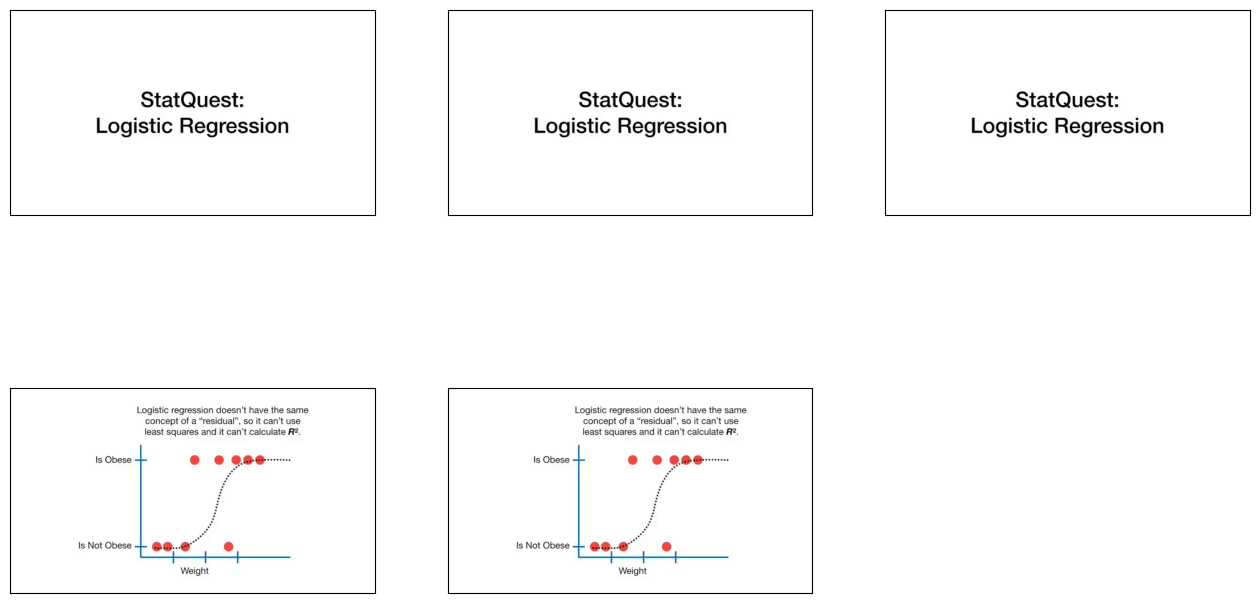

In [44]:
plot_images(img)

In [ ]:
# !pip install yt-dlp
# !pip install ffmpeg-python

In [ ]:
# import yt_dlp
# import os
# import json
# from pathlib import Path

# def download_video_with_ytdlp(url, output_path):
#     """
#     Download video using yt-dlp with comprehensive metadata extraction
#     """
#     # Create output directory
#     os.makedirs(output_path, exist_ok=True)

#     # Configure yt-dlp options
#     ydl_opts = {
#         'format': 'best[ext=mp4][height<=720]/best[ext=mp4]/best',  # Prefer mp4, max 720p for efficiency
#         'outtmpl': os.path.join(output_path, 'input_vid.%(ext)s'),
#         'writeinfojson': True,  # Save metadata to JSON file
#         'writethumbnail': True,  # Download thumbnail
#         'writesubtitles': False,  # Set to True if you want subtitles
#         'writeautomaticsub': False,  # Set to True for auto-generated subtitles
#     }

#     try:
#         print(f"🎥 Starting download from: {url}")

#         with yt_dlp.YoutubeDL(ydl_opts) as ydl:
#             # Extract info first
#             info = ydl.extract_info(url, download=False)

#             # Print basic info
#             print(f"📹 Title: {info.get('title', 'Unknown')}")
#             print(f"👤 Author: {info.get('uploader', 'Unknown')}")
#             print(f"⏱️ Duration: {info.get('duration', 0)} seconds")
#             print(f"👀 Views: {info.get('view_count', 0):,}")

#             # Now download
#             ydl.download([url])

#             # Extract comprehensive metadata
#             metadata = extract_comprehensive_metadata(info)

#             print("✅ Video downloaded successfully!")
#             return metadata, info

#     except Exception as e:
#         print(f"❌ Download failed: {e}")
#         return None, None

# def extract_comprehensive_metadata(info):
#     """
#     Extract comprehensive metadata from yt-dlp info
#     """
#     metadata = {
#         # Basic Info
#         "title": info.get('title', 'Unknown'),
#         "uploader": info.get('uploader', 'Unknown'),
#         "uploader_id": info.get('uploader_id', 'Unknown'),
#         "channel": info.get('channel', 'Unknown'),
#         "channel_id": info.get('channel_id', 'Unknown'),

#         # Video Details
#         "duration": info.get('duration', 0),
#         "view_count": info.get('view_count', 0),
#         "like_count": info.get('like_count', 0),
#         "upload_date": info.get('upload_date', 'Unknown'),
#         "description": info.get('description', 'No description')[:500],  # First 500 chars

#         # Technical Details
#         "width": info.get('width', 0),
#         "height": info.get('height', 0),
#         "fps": info.get('fps', 0),
#         "format": info.get('format', 'Unknown'),
#         "filesize": info.get('filesize', 0),

#         # Additional
#         "tags": info.get('tags', [])[:10],  # First 10 tags
#         "categories": info.get('categories', []),
#         "thumbnail": info.get('thumbnail', ''),
#         "webpage_url": info.get('webpage_url', ''),
#     }

#     return metadata

In [ ]:
# from moviepy.editor import VideoFileClip
# import cv2
# import numpy as np

# def get_video_file_path(output_path):
#     """Find the downloaded video file"""
#     video_extensions = ['.mp4', '.mkv', '.webm', '.avi']

#     for ext in video_extensions:
#         video_path = os.path.join(output_path, f'input_vid{ext}')
#         if os.path.exists(video_path):
#             return video_path

#     # If not found with expected name, look for any video file
#     for file in os.listdir(output_path):
#         if any(file.endswith(ext) for ext in video_extensions):
#             return os.path.join(output_path, file)

#     return None

# def video_to_images_enhanced(video_path, output_folder, fps=0.5, max_frames=50):
#     """
#     Extract frames from video with enhanced options
#     """
#     os.makedirs(output_folder, exist_ok=True)

#     try:
#         clip = VideoFileClip(video_path)
#         duration = clip.duration

#         print(f"🎬 Video duration: {duration:.2f} seconds")
#         print(f"📸 Extracting frames at {fps} FPS...")

#         # Calculate frame interval
#         interval = 1.0 / fps
#         frame_count = 0

#         for t in np.arange(0, min(duration, max_frames * interval), interval):
#             if frame_count >= max_frames:
#                 break

#             frame_path = os.path.join(output_folder, f"frame_{frame_count:04d}.png")
#             clip.save_frame(frame_path, t)
#             frame_count += 1

#         clip.close()
#         print(f"✅ Extracted {frame_count} frames")
#         return frame_count

#     except Exception as e:
#         print(f"❌ Frame extraction failed: {e}")
#         return 0

# def video_to_audio_enhanced(video_path, output_audio_path):
#     """
#     Extract audio with enhanced options
#     """
#     try:
#         clip = VideoFileClip(video_path)
#         audio = clip.audio

#         # Extract audio
#         audio.write_audiofile(
#             output_audio_path,
#             codec='pcm_s16le',  # WAV format
#             verbose=False,
#             logger=None
#         )

#         clip.close()
#         print(f"🎵 Audio extracted to: {output_audio_path}")
#         return True

#     except Exception as e:
#         print(f"❌ Audio extraction failed: {e}")
#         return False

In [ ]:
# def process_video_complete(video_url, base_output_path="/content"):
#     """
#     Complete video processing pipeline
#     """
#     # Setup paths
#     video_output_path = os.path.join(base_output_path, "video_data")
#     mixed_output_path = os.path.join(base_output_path, "mixed_data")
#     frames_output_path = os.path.join(mixed_output_path, "frames")
#     audio_output_path = os.path.join(mixed_output_path, "output_audio.wav")

#     # Create directories
#     os.makedirs(video_output_path, exist_ok=True)
#     os.makedirs(mixed_output_path, exist_ok=True)
#     os.makedirs(frames_output_path, exist_ok=True)

#     print("🚀 Starting complete video processing pipeline...")

#     # Step 1: Download video
#     print("\n📥 Step 1: Downloading video...")
#     metadata, full_info = download_video_with_ytdlp(video_url, video_output_path)

#     if not metadata:
#         print("❌ Failed to download video")
#         return None

#     # Step 2: Find video file
#     video_path = get_video_file_path(video_output_path)
#     if not video_path:
#         print("❌ Could not find downloaded video file")
#         return None

#     print(f"📹 Video file: {video_path}")

#     # Step 3: Extract frames
#     print("\n🖼️ Step 2: Extracting frames...")
#     frame_count = video_to_images_enhanced(video_path, frames_output_path, fps=0.3, max_frames=30)

#     # Step 4: Extract audio
#     print("\n🎵 Step 3: Extracting audio...")
#     audio_success = video_to_audio_enhanced(video_path, audio_output_path)

#     # Step 5: Audio to text (if needed)
#     text_content = ""
#     if audio_success:
#         print("\n📝 Step 4: Converting audio to text...")
#         try:
#             text_content = audio_to_text(audio_output_path)
#             print(f"📄 Extracted text length: {len(text_content)} characters")
#         except Exception as e:
#             print(f"⚠️ Audio to text conversion failed: {e}")

#     # Compile results
#     results = {
#         "metadata": metadata,
#         "video_path": video_path,
#         "frames_path": frames_output_path,
#         "frame_count": frame_count,
#         "audio_path": audio_output_path if audio_success else None,
#         "text_content": text_content,
#         "full_info": full_info
#     }

#     print("\n✅ Processing complete!")
#     print(f"📊 Summary:")
#     print(f"   - Video: {metadata['title']}")
#     print(f"   - Duration: {metadata['duration']} seconds")
#     print(f"   - Frames extracted: {frame_count}")
#     print(f"   - Audio extracted: {'Yes' if audio_success else 'No'}")
#     print(f"   - Text extracted: {'Yes' if text_content else 'No'}")

#     return results

In [ ]:
# # Your video URL
# video_url = "https://youtu.be/yIYKR4sgzI8?si=gXmg-aTIhioj1pOs"

# # Process the video
# results = process_video_complete(video_url)

# if results:
#     print("\n📋 Detailed Results:")
#     pprint(results["metadata"])

#     # Save metadata to file
#     import json
#     with open("/content/mixed_data/video_metadata.json", "w") as f:
#         json.dump(results["metadata"], f, indent=2)

#     print("\n💾 Metadata saved to video_metadata.json")
# else:
#     print("❌ Video processing failed")